# Garbage Classification using MobilenetV2

# Import Required Libraries

In [1]:
import numpy as np
import pandas as pd 
import random
import os
import matplotlib.pyplot as plt
import seaborn as sns
import sys
import time
import tensorflow as tf
import tensorflow.keras as keras
import re
from pathlib import Path

from PIL import Image
from tensorflow.keras.layers import Input, Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing import image
from tensorflow.keras.layers import Lambda
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import tensorflow.keras.applications.mobilenet_v2 as mobilenetv2

print("Setup successful! TensorFlow version:", tf.__version__)

Setup successful! TensorFlow version: 2.20.0


# Define Constants

In [8]:
# Get the current working directory (should be the repo root when running notebook)
PROJECT_ROOT = Path.cwd()
if PROJECT_ROOT.name == 'models':  # If running from models folder
    PROJECT_ROOT = PROJECT_ROOT.parent

print(f"Project root: {PROJECT_ROOT}")

# Data configuration
DATA_PATH = PROJECT_ROOT / "Garbage classification"  # Adjust if your data is elsewhere
MODEL_SAVE_PATH = PROJECT_ROOT / "models"
RESULTS_PATH = PROJECT_ROOT / "results"

# Create directories if they don't exist
MODEL_SAVE_PATH.mkdir(exist_ok=True)
RESULTS_PATH.mkdir(exist_ok=True)

# Image configuration
IMAGE_WIDTH = 224
IMAGE_HEIGHT = 224
IMAGE_SIZE = (IMAGE_WIDTH, IMAGE_HEIGHT)
IMAGE_CHANNELS = 3

# Class configuration
categories = {0: 'paper', 1: 'cardboard', 2: 'plastic', 3: 'metal', 4: 'trash', 5: 'glass'}

print("Configuration completed!")

Project root: /Users/donaldheddesheimer/Documents/GitHub/Smart-Bin/src
Configuration completed!


# Create DataFrame

We want to create a data frame that has in one column the filenames of all our images and in the other column the corresponding category. 
We Open the directories in the dataset one by one, save the filenames in the filenames_list and add the corresponding category in the categories_list

Found 594 images in paper
Found 403 images in cardboard
Found 482 images in plastic
Found 410 images in metal
Found 137 images in trash
Found 501 images in glass
Total images loaded: 2527
Dataset shape: (2527, 2)

First few rows:
                     filename  category
0      plastic/plastic465.jpg         2
1  cardboard/cardboard133.jpg         1
2       plastic/plastic60.jpg         2
3      plastic/plastic232.jpg         2
4          glass/glass182.jpg         5


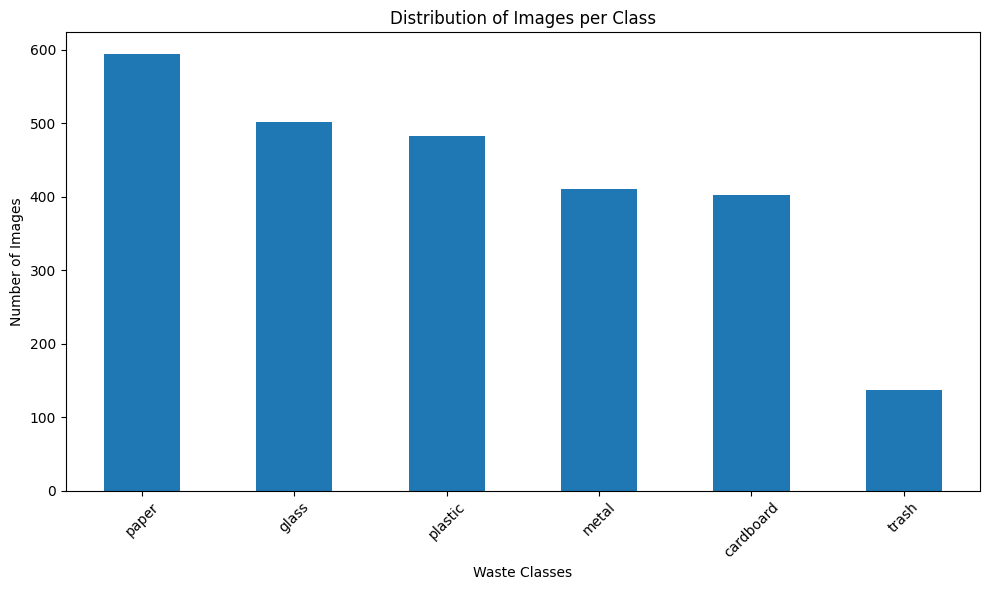


Class distribution:
category
paper        594
glass        501
plastic      482
metal        410
cardboard    403
trash        137
Name: count, dtype: int64


In [9]:
def prepare_dataset_from_structure(data_path):
    """
    Prepare dataset from organized folder structure:
    data/
    ├── paper/
    ├── cardboard/
    ├── plastic/
    ├── metal/
    ├── trash/
    └── glass/
    """
    if not data_path.exists():
        print(f"Data path {data_path} does not exist!")
        print("Please organize your data in the following structure:")
        print("data/")
        for cat in categories.values():
            print(f"├── {cat}/")
        return None
    
    filenames_list = []
    categories_list = []
    
    for category_id, category_name in categories.items():
        category_path = data_path / category_name
        
        if not category_path.exists():
            print(f"Warning: {category_path} does not exist, skipping...")
            continue
        
        # Get all image files
        image_extensions = ['.jpg', '.jpeg', '.png', '.bmp', '.tiff']
        image_files = []
        
        for ext in image_extensions:
            image_files.extend(category_path.glob(f'*{ext}'))
            image_files.extend(category_path.glob(f'*{ext.upper()}'))
        
        print(f"Found {len(image_files)} images in {category_name}")
        
        for img_file in image_files:
            # Store relative path from data directory
            relative_path = f"{category_name}/{img_file.name}"
            filenames_list.append(relative_path)
            categories_list.append(category_id)
    
    if not filenames_list:
        print("No images found! Please check your data structure.")
        return None
    
    df = pd.DataFrame({
        'filename': filenames_list,
        'category': categories_list
    })
    
    # Shuffle the dataframe
    df = df.sample(frac=1).reset_index(drop=True)
    
    print(f"Total images loaded: {len(df)}")
    return df

# Prepare the dataset
df = prepare_dataset_from_structure(DATA_PATH)

if df is None:
    print("Could not load dataset. Please check your data organization.")
    # Create sample data structure guide
    print("\nTo use this notebook, organize your data like this:")
    print("Smart-Bin/")
    print("├── data/")
    print("│   ├── paper/        # Put paper waste images here")
    print("│   ├── cardboard/    # Put cardboard images here") 
    print("│   ├── plastic/      # Put plastic images here")
    print("│   ├── metal/        # Put metal images here")
    print("│   ├── trash/        # Put general trash images here")
    print("│   └── glass/        # Put glass images here")
    print("└── ...")
else:
    # Display dataset info
    print(f"Dataset shape: {df.shape}")
    print("\nFirst few rows:")
    print(df.head())
    
    # Visualize class distribution
    df_viz = df.copy()
    df_viz['category'] = df_viz['category'].replace(categories)
    
    plt.figure(figsize=(10, 6))
    df_viz['category'].value_counts().plot.bar()
    plt.xlabel("Waste Classes")
    plt.ylabel("Number of Images")
    plt.title("Distribution of Images per Class")
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()
    
    print("\nClass distribution:")
    print(df_viz['category'].value_counts())


In [10]:
df.head()

,filename,category
0,plastic/plastic465.jpg,2
1,cardboard/cardboard133.jpg,1
2,plastic/plastic60.jpg,2
3,plastic/plastic232.jpg,2
4,glass/glass182.jpg,5


# Viusalize the Categories Distribution

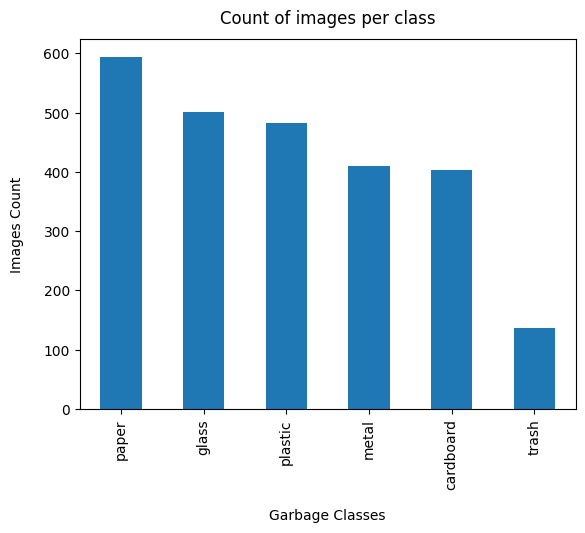

In [12]:
df_visualization = df.copy()
# Change the catgegories from numbers to names
df_visualization['category'] = df_visualization['category'].apply(lambda x:categories[x] )

df_visualization['category'].value_counts().plot.bar(x = 'count', y = 'category' )

plt.xlabel("Garbage Classes", labelpad=14)
plt.ylabel("Images Count", labelpad=14)
plt.title("Count of images per class", y=1.02);

# Create the model

The steps are:
1. Create an mobilenetv2 model without the last layer and load the ImageNet pretrained weights
2. Add a pre-processing layer
3. Add a pooling layer followed by a softmax layer at the end

In [13]:
def create_mobilenet_model():
    """Create MobileNetV2-based model for waste classification."""
    
    # Create MobileNetV2 base model (will download weights automatically)
    print("Loading MobileNetV2 base model...")
    try:
        mobilenetv2_layer = mobilenetv2.MobileNetV2(
            include_top=False, 
            input_shape=(IMAGE_WIDTH, IMAGE_HEIGHT, IMAGE_CHANNELS),
            weights='imagenet'  # This will download ImageNet weights automatically
        )
        print("MobileNetV2 loaded successfully!")
    except Exception as e:
        print(f"Error loading MobileNetV2: {e}")
        print("You might need an internet connection to download the pre-trained weights.")
        return None
    
    # Freeze the base model
    mobilenetv2_layer.trainable = False
    
    # Create the full model
    model = Sequential([
        Input(shape=(IMAGE_WIDTH, IMAGE_HEIGHT, IMAGE_CHANNELS)),
        
        # Preprocessing layer
        Lambda(lambda x: mobilenetv2.preprocess_input(x), name='preprocessing'),
        
        # MobileNetV2 base
        mobilenetv2_layer,
        
        # Classification head
        GlobalAveragePooling2D(),
        Dense(len(categories), activation='softmax', name='predictions')
    ])
    
    # Compile the model
    model.compile(
        loss='categorical_crossentropy',
        optimizer='adam',
        metrics=['categorical_accuracy']
    )
    
    print("Model created and compiled!")
    model.summary()
    
    return model

# Create the model
if df is not None:
    model = create_mobilenet_model()
else:
    model = None
    print("Skipping model creation due to dataset issues.")


Loading MobileNetV2 base model...
MobileNetV2 loaded successfully!
Model created and compiled!


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ preprocessing (Lambda)          │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ mobilenetv2_1.00_224            │ (None, 7, 7, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ predictions (Dense)             │ (None, 6)              │         7,686 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,265,670 (8.64 MB)

 Trainable params: 7,686 (30.02 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

We will use the EarlyStopping call back to stop our training if the validation_accuray is not improving for a certain number of epochs.

In [14]:
early_stop = EarlyStopping(patience = 2, verbose = 1, monitor='val_categorical_accuracy' , mode='max', min_delta=0.001, restore_best_weights = True)

callbacks = [early_stop]

print('call back defined!')


call back defined!


# Split the Data Set

We split the training set into three separate sets:

1. **The training set:** used to train our model.
1. **The validation set**: used to double check that our model is not overfitting the training set, i.e. it can also generalise to other data other than the train data
1. **The Test set:** Used to estimate the accuracy of the model on new data other than the ones the model used for training
For a competition  or for some other cases, you can split the data only to training and validation sets in order to achieve the highest  possible accuracy, without the need to properly estimate how accurate the model really is.

We split the data set as follows: 80% train set, 10% cross_validation set, and 10% test set

In [15]:
if df is not None and model is not None:
    # Convert categories to names for data generators
    df["category"] = df["category"].replace(categories)
    
    # Split the dataset
    print("Splitting dataset...")
    train_df, temp_df = train_test_split(df, test_size=0.3, random_state=42, stratify=df['category'])
    val_df, test_df = train_test_split(temp_df, test_size=0.5, random_state=42, stratify=temp_df['category'])
    
    train_df = train_df.reset_index(drop=True)
    val_df = val_df.reset_index(drop=True)
    test_df = test_df.reset_index(drop=True)
    
    print(f"Training samples: {len(train_df)}")
    print(f"Validation samples: {len(val_df)}")
    print(f"Test samples: {len(test_df)}")
    
    # Create data generators
    batch_size = 32  # Reduced for better compatibility
    
    # Training generator with augmentation
    train_datagen = image.ImageDataGenerator(
        rescale=1./255,
        rotation_range=30,
        shear_range=0.1,
        zoom_range=0.3,
        horizontal_flip=True,
        vertical_flip=True,
        width_shift_range=0.2,
        height_shift_range=0.2,
        fill_mode='nearest'
    )
    
    # Validation generator (no augmentation)
    val_datagen = image.ImageDataGenerator(rescale=1./255)
    
    print("Creating data generators...")
    
    train_generator = train_datagen.flow_from_dataframe(
        train_df,
        str(DATA_PATH),
        x_col='filename',
        y_col='category',
        target_size=IMAGE_SIZE,
        class_mode='categorical',
        batch_size=batch_size,
        shuffle=True
    )
    
    val_generator = val_datagen.flow_from_dataframe(
        val_df,
        str(DATA_PATH),
        x_col='filename',
        y_col='category',
        target_size=IMAGE_SIZE,
        class_mode='categorical',
        batch_size=batch_size,
        shuffle=False
    )
    
    print("Data generators created successfully!")
    print(f"Class indices: {train_generator.class_indices}")


Splitting dataset...
Training samples: 1768
Validation samples: 379
Test samples: 380
Creating data generators...
Found 1768 validated image filenames belonging to 6 classes.
Found 379 validated image filenames belonging to 6 classes.
Data generators created successfully!
Class indices: {'cardboard': 0, 'glass': 1, 'metal': 2, 'paper': 3, 'plastic': 4, 'trash': 5}


In [16]:
if df is not None and model is not None:
    # Create callbacks for better training
    callbacks = [
        EarlyStopping(
            patience=3,
            verbose=1,
            monitor='val_categorical_accuracy',
            mode='max',
            min_delta=0.001,
            restore_best_weights=True
        ),
        ModelCheckpoint(
            str(MODEL_SAVE_PATH / 'best_model.h5'),
            monitor='val_categorical_accuracy',
            save_best_only=True,
            mode='max',
            verbose=1
        ),
        ReduceLROnPlateau(
            monitor='val_categorical_accuracy',
            factor=0.2,
            patience=2,
            min_lr=1e-7,
            verbose=1,
            mode='max'
        )
    ]
    
    print("Callbacks created!")

Callbacks created!


# Train the model

We will first create the training data generator, that will get the images from the input data directory to train on them. We will also create a generator for the validation set.

Applying Data Augmentation on the training set was taking too long to be executed and the initial results didn't show much improvement than the results without augmentation, so I commented the augmentation to make the training faster. However fell free to uncomment the Data Augmentation lines in the following cell and play a bit with it.

In [17]:
if df is not None and model is not None:
    print("Starting training...")
    
    # Training configuration
    EPOCHS = 10  # Reduced for initial testing
    
    # Calculate steps
    steps_per_epoch = len(train_generator)
    validation_steps = len(val_generator)
    
    print(f"Steps per epoch: {steps_per_epoch}")
    print(f"Validation steps: {validation_steps}")
    
    # Train the model
    history = model.fit(
        train_generator,
        epochs=EPOCHS,
        validation_data=val_generator,
        steps_per_epoch=steps_per_epoch,
        validation_steps=validation_steps,
        callbacks=callbacks,
        verbose=1
    )
    
    print("Training completed!")
    
    # Save the final model
    final_model_path = MODEL_SAVE_PATH / 'smart_bin_model_final.h5'
    model.save(str(final_model_path))
    print(f"Final model saved to: {final_model_path}")


Starting training...
Steps per epoch: 56
Validation steps: 12


/Users/donaldheddesheimer/miniforge3/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step - categorical_accuracy: 0.2137 - loss: 1.8445
Epoch 1: val_categorical_accuracy improved from None to 0.23219, saving model to /Users/donaldheddesheimer/Documents/GitHub/Smart-Bin/src/models/best_model.h5


56/56 ━━━━━━━━━━━━━━━━━━━━ 14s 201ms/step - categorical_accuracy: 0.2240 - loss: 1.7799 - val_categorical_accuracy: 0.2322 - val_loss: 1.7236 - learning_rate: 0.0010
Epoch 2/10
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step - categorical_accuracy: 0.2079 - loss: 1.7398
Epoch 2: val_categorical_accuracy improved from 0.23219 to 0.30079, saving model to /Users/donaldheddesheimer/Documents/GitHub/Smart-Bin/src/models/best_model.h5


56/56 ━━━━━━━━━━━━━━━━━━━━ 11s 189ms/step - categorical_accuracy: 0.2178 - loss: 1.7401 - val_categorical_accuracy: 0.3008 - val_loss: 1.7133 - learning_rate: 0.0010
Epoch 3/10
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step - categorical_accuracy: 0.2638 - loss: 1.7141
Epoch 3: val_categorical_accuracy did not improve from 0.30079
56/56 ━━━━━━━━━━━━━━━━━━━━ 11s 189ms/step - categorical_accuracy: 0.2466 - loss: 1.7275 - val_categorical_accuracy: 0.2427 - val_loss: 1.7059 - learning_rate: 0.0010
Epoch 4/10
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step - categorical_accuracy: 0.2215 - loss: 1.7064
Epoch 4: val_categorical_accuracy did not improve from 0.30079

Epoch 4: ReduceLROnPlateau reducing learning rate to 0.00020000000949949026.
56/56 ━━━━━━━━━━━━━━━━━━━━ 11s 191ms/step - categorical_accuracy: 0.2370 - loss: 1.7275 - val_categorical_accuracy: 0.2929 - val_loss: 1.6934 - learning_rate: 0.0010
Epoch 5/10
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step - categorical_accuracy: 0.2491 - loss: 1.7199
Epoc

Training completed!
Final model saved to: /Users/donaldheddesheimer/Documents/GitHub/Smart-Bin/src/models/smart_bin_model_final.h5


# Visualize the training process


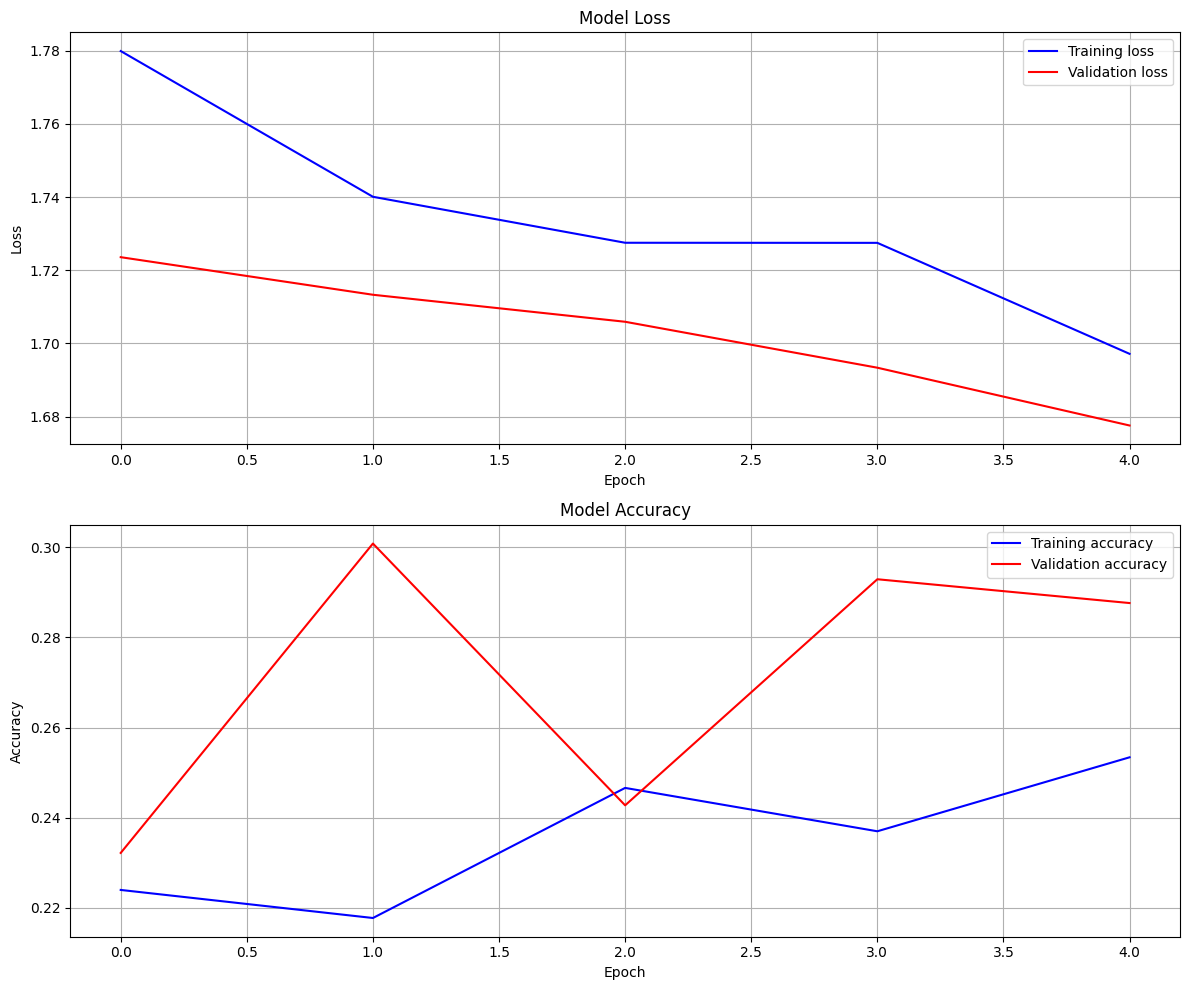

Training plots saved to: /Users/donaldheddesheimer/Documents/GitHub/Smart-Bin/src/results/training_history.png


In [19]:
if df is not None and model is not None and 'history' in locals():
    # Plot training history
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 10))
    
    # Plot loss
    ax1.plot(history.history['loss'], 'b-', label="Training loss")
    ax1.plot(history.history['val_loss'], 'r-', label="Validation loss")
    ax1.set_title('Model Loss')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Loss')
    ax1.legend()
    ax1.grid(True)
    
    # Plot accuracy
    ax2.plot(history.history['categorical_accuracy'], 'b-', label="Training accuracy")
    ax2.plot(history.history['val_categorical_accuracy'], 'r-', label="Validation accuracy")
    ax2.set_title('Model Accuracy')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Accuracy')
    ax2.legend()
    ax2.grid(True)
    
    plt.tight_layout()
    plt.savefig(RESULTS_PATH / 'training_history.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    print(f"Training plots saved to: {RESULTS_PATH / 'training_history.png'}")


# Evaluate the test

To evaluate the performance of our model we will create a test generator to load the images from the input data directory and evaluate the results.

Evaluating model on test set...
Found 380 validated image filenames belonging to 6 classes.
 11/380 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - categorical_accuracy: 0.2894 - loss: 1.6641    

/Users/donaldheddesheimer/miniforge3/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


380/380 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - categorical_accuracy: 0.2842 - loss: 1.7116
Test Accuracy: 28.42%
Test Loss: 1.7116
Generating predictions...
380/380 ━━━━━━━━━━━━━━━━━━━━ 5s 11ms/step

Classification Report:
              precision    recall  f1-score   support

   cardboard       0.00      0.00      0.00        60
       glass       0.00      0.00      0.00        76
       metal       0.00      0.00      0.00        62
       paper       0.43      0.49      0.46        89
     plastic       0.23      0.88      0.37        73
       trash       0.00      0.00      0.00        20

    accuracy                           0.28       380
   macro avg       0.11      0.23      0.14       380
weighted avg       0.14      0.28      0.18       380



/Users/donaldheddesheimer/miniforge3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/Users/donaldheddesheimer/miniforge3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/Users/donaldheddesheimer/miniforge3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{me

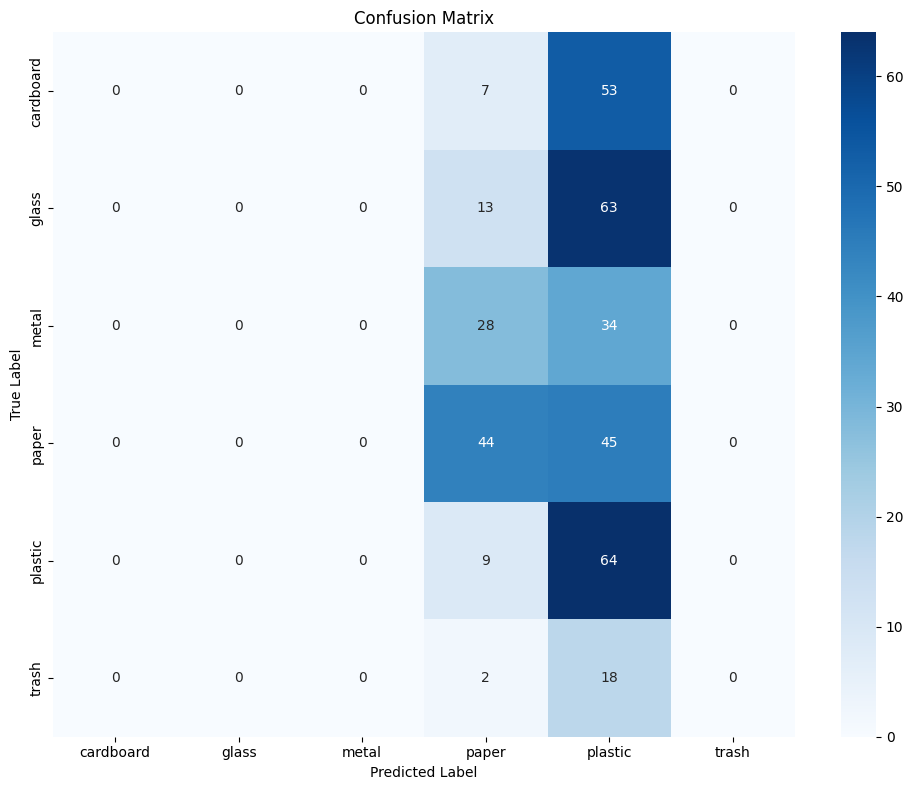

Confusion matrix saved to: /Users/donaldheddesheimer/Documents/GitHub/Smart-Bin/src/results/confusion_matrix.png


In [20]:
if df is not None and model is not None:
    print("Evaluating model on test set...")
    
    # Create test generator
    test_datagen = image.ImageDataGenerator(rescale=1./255)
    
    test_generator = test_datagen.flow_from_dataframe(
        test_df,
        str(DATA_PATH),
        x_col='filename',
        y_col='category',
        target_size=IMAGE_SIZE,
        color_mode="rgb",
        class_mode="categorical",
        batch_size=1,
        shuffle=False
    )
    
    # Evaluate model
    test_loss, test_accuracy = model.evaluate(test_generator, verbose=1)
    print(f'Test Accuracy: {test_accuracy*100:.2f}%')
    print(f'Test Loss: {test_loss:.4f}')
    
    # Generate predictions for classification report
    print("Generating predictions...")
    predictions = model.predict(test_generator, verbose=1)
    predicted_classes = predictions.argmax(axis=1)
    
    # Get true labels
    true_classes = test_generator.classes
    class_labels = list(test_generator.class_indices.keys())
    
    # Print classification report
    print("\nClassification Report:")
    print(classification_report(true_classes, predicted_classes, target_names=class_labels))
    
    # Plot confusion matrix
    cm = confusion_matrix(true_classes, predicted_classes)
    
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=class_labels, yticklabels=class_labels)
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.tight_layout()
    plt.savefig(RESULTS_PATH / 'confusion_matrix.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    print(f"Confusion matrix saved to: {RESULTS_PATH / 'confusion_matrix.png'}")


In [22]:
# We defined at the beginning of this notebook a dictionary that maps the categories number to names, but the train generator
# generated it's own dictionary and it has assigned different numbers to our categories and the predictions made by the model 
# will be made using the genrator's dictionary.

gen_label_map = test_generator.class_indices
gen_label_map = dict((v,k) for k,v in gen_label_map.items())
print(gen_label_map)

{0: 'cardboard', 1: 'glass', 2: 'metal', 3: 'paper', 4: 'plastic', 5: 'trash'}


In [24]:
print("\n" + "="*60)
print("TRAINING SUMMARY")
print("="*60)

if df is not None and model is not None and 'history' in locals():
    final_train_acc = history.history['categorical_accuracy'][-1]
    final_val_acc = history.history['val_categorical_accuracy'][-1]
    
    print(f"Final Training Accuracy: {final_train_acc*100:.2f}%")
    print(f"Final Validation Accuracy: {final_val_acc*100:.2f}%")
    if 'test_accuracy' in locals():
        print(f"Test Accuracy: {test_accuracy*100:.2f}%")
    
    print(f"\nModel saved to: {MODEL_SAVE_PATH / 'best_model.h5'}")
    print(f"Results saved to: {RESULTS_PATH}")
    
    print("\n" + "="*60)
    print("NEXT STEPS")
    print("="*60)
    print("1. Test your model with the CLI:")
    print(f"   python classify_waste.py --image test_image.jpg --model {MODEL_SAVE_PATH / 'best_model.h5'}")
    print()
    print("2. Start the web API:")
    print("   python api/app.py")
    print()
    print("3. Run unit tests:")
    print("   python -m pytest tests/ -v")
    
else:
    print("Training was not completed. Please check:")
    print("1. Data organization in the 'data' folder")
    print("2. Internet connection for downloading MobileNetV2 weights")
    print("3. Required dependencies are installed")

print("\n" + "="*60)


TRAINING SUMMARY
Final Training Accuracy: 25.34%
Final Validation Accuracy: 28.76%
Test Accuracy: 28.42%

Model saved to: /Users/donaldheddesheimer/Documents/GitHub/Smart-Bin/src/models/best_model.h5
Results saved to: /Users/donaldheddesheimer/Documents/GitHub/Smart-Bin/src/results

NEXT STEPS
1. Test your model with the CLI:
   python classify_waste.py --image test_image.jpg --model /Users/donaldheddesheimer/Documents/GitHub/Smart-Bin/src/models/best_model.h5

2. Start the web API:
   python api/app.py

3. Run unit tests:
   python -m pytest tests/ -v

